<a href="https://colab.research.google.com/github/sinaabbasi1/Trustworthy_AI/blob/main/Assignments/Assignment%2002/TAI_Assignment_02_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

First, we import libraries we'll need later.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random
import copy
from PIL import Image
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

!pip install lime
!pip install shap
from lime import lime_image
import shap

import urllib
import os

clear_output()

Setting the device option:

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Question 1 - SHAP

Using Shapley values is one of the effective ways to evaluate the impact of individual features on the model's output in relation to other features (coalitions). In this context, **SHAP (SHapley Additive exPlanations)** provides an efficient method for explaining model behavior.

## Part A: SHAP Overview

Provide answers to the following:

1. **Additive Feature Attribution:** Briefly introduce SHAP and explain its three unique properties: *local accuracy*, *missingness*, and *consistency*.

2. **Kernel SHAP:** To address the high computational complexity of SHAP value calculations, a model-agnostic method called Kernel SHAP has been introduced. Explain how this method works compared to the exact computation of SHAP values.

3. **Deep SHAP:** In addition to model-agnostic methods, this paper introduces Deep SHAP, a model-specific approach for neural networks. Discuss the differences between Deep SHAP and Kernel SHAP.

## Part B: Applying SHAP Deep and SHAP Kernel

The goal of this section is to use **SHAP Deep** and **SHAP Kernel** to explain the behavior of a linear regression model:

1. **Data Preparation:**

    - Obtain the **Life Expectancy** dataset.
    - Implement a simple regression model with a custom architecture to predict life expectancy, ensuring it achieves reasonably good performance.
    - Split the data into **10% for testing** and **90% for training**, ensuring that the test set includes samples from at least one country from three different continents.

2. **Feature Importance:**

    - Use the SHAP library to compute SHAP values for all test samples and features using both SHAP Kernel and SHAP Deep.
    - Visualize the results using the `summary_plot` function to highlight the impact of each feature on the model's output.
    - Analyze the results.

3. **Force Plot:**

    - Select a sample from two countries in the same continent and generate a `force_plot` for the selected sample.
    - Display the results and provide a brief explanation, focusing only on feature importance analysis (other types of analysis are optional).

For this question, first we need to download [Life Expectancy](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who) dataset from the kaggle.

In [ ]:
!pip install -q kaggle
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
!kaggle datasets download -d kumarajarshi/life-expectancy-who
clear_output()

In [ ]:
!unzip \*.zip && rm *.zip
clear_output()

## Data Preprocessing

First, we load our data as pandas dataframe:

In [ ]:
df = pd.read_csv('/content/Life Expectancy Data.csv')
print(df.shape)

(2938, 22)


Get some info from our dataset:

In [ ]:
df.head(50)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,...,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,...,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,...,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,...,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

There are lots of `null` values:

In [ ]:
df.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

First we drop columns with huge amount of `null` values:

In [ ]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [ ]:
df = df.drop(columns=['GDP', 'Population', 'Total expenditure', 'Hepatitis B'])
df = df.dropna()
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,1154,19.1,83,6.0,65.0,0.1,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,492,18.6,86,58.0,62.0,0.1,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,430,18.1,89,62.0,64.0,0.1,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,2787,17.6,93,67.0,67.0,0.1,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,3013,17.2,97,68.0,68.0,0.1,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,31,27.1,42,67.0,65.0,33.6,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,998,26.7,41,7.0,68.0,36.7,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,304,26.3,40,73.0,71.0,39.8,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,529,25.9,39,76.0,75.0,42.1,1.6,1.7,0.427,9.8


In [ ]:
df.head(50)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,1154,19.1,83,6.0,65.0,0.1,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,492,18.6,86,58.0,62.0,0.1,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,430,18.1,89,62.0,64.0,0.1,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,2787,17.6,93,67.0,67.0,0.1,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,3013,17.2,97,68.0,68.0,0.1,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,1989,16.7,102,66.0,66.0,0.1,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,2861,16.2,106,63.0,63.0,0.1,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,1599,15.7,110,64.0,64.0,0.1,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,1141,15.2,113,63.0,63.0,0.1,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,1990,14.7,116,58.0,58.0,0.1,19.2,19.3,0.405,8.1


As we can see some of our data isn't numerical so we need to encode those columns:

In [ ]:
c = list()
d = list()
to_categorical_columns = ['Country','Status']
for idx, column in enumerate(to_categorical_columns):
    c.append(df[column].astype('category'))
    d.append(dict(enumerate(c[idx].cat.categories)))
    print(d[idx])


{0: 'Afghanistan', 1: 'Albania', 2: 'Algeria', 3: 'Angola', 4: 'Antigua and Barbuda', 5: 'Argentina', 6: 'Armenia', 7: 'Australia', 8: 'Austria', 9: 'Azerbaijan', 10: 'Bahamas', 11: 'Bahrain', 12: 'Bangladesh', 13: 'Barbados', 14: 'Belarus', 15: 'Belgium', 16: 'Belize', 17: 'Benin', 18: 'Bhutan', 19: 'Bolivia (Plurinational State of)', 20: 'Bosnia and Herzegovina', 21: 'Botswana', 22: 'Brazil', 23: 'Brunei Darussalam', 24: 'Bulgaria', 25: 'Burkina Faso', 26: 'Burundi', 27: 'Cabo Verde', 28: 'Cambodia', 29: 'Cameroon', 30: 'Canada', 31: 'Central African Republic', 32: 'Chad', 33: 'Chile', 34: 'China', 35: 'Colombia', 36: 'Comoros', 37: 'Congo', 38: 'Costa Rica', 39: 'Croatia', 40: 'Cuba', 41: 'Cyprus', 42: 'Denmark', 43: 'Djibouti', 44: 'Dominican Republic', 45: 'Ecuador', 46: 'Egypt', 47: 'El Salvador', 48: 'Equatorial Guinea', 49: 'Eritrea', 50: 'Estonia', 51: 'Ethiopia', 52: 'Fiji', 53: 'Finland', 54: 'France', 55: 'Gabon', 56: 'Gambia', 57: 'Georgia', 58: 'Germany', 59: 'Ghana', 60:

In [ ]:
to_categorical_columns = ['Country','Status']
for column in to_categorical_columns:
    df[column] = df[column].astype('category').cat.codes
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0,2015,1,65.0,263.0,62,0.01,71.279624,1154,19.1,83,6.0,65.0,0.1,17.2,17.3,0.479,10.1
1,0,2014,1,59.9,271.0,64,0.01,73.523582,492,18.6,86,58.0,62.0,0.1,17.5,17.5,0.476,10.0
2,0,2013,1,59.9,268.0,66,0.01,73.219243,430,18.1,89,62.0,64.0,0.1,17.7,17.7,0.470,9.9
3,0,2012,1,59.5,272.0,69,0.01,78.184215,2787,17.6,93,67.0,67.0,0.1,17.9,18.0,0.463,9.8
4,0,2011,1,59.2,275.0,71,0.01,7.097109,3013,17.2,97,68.0,68.0,0.1,18.2,18.2,0.454,9.5


Detach the target column:

In [ ]:
target = df.pop('Life expectancy ')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df_scaled = df
scaler = MinMaxScaler()
df_scaled[df.columns] = scaler.fit_transform(df[df.columns])

In [ ]:
df.head(50)

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0.000000,1.000000,1.0,0.362881,0.034444,0.000000,0.003659,0.005439,0.237845,0.0332,0.031250,0.649485,0.000000,0.619565,0.603509,0.505274,0.487923
1,0.000000,0.933333,1.0,0.373961,0.035556,0.000000,0.003774,0.002319,0.231275,0.0344,0.572917,0.618557,0.000000,0.630435,0.610526,0.502110,0.483092
2,0.000000,0.866667,1.0,0.369806,0.036667,0.000000,0.003759,0.002027,0.224704,0.0356,0.614583,0.639175,0.000000,0.637681,0.617544,0.495781,0.478261
3,0.000000,0.800000,1.0,0.375346,0.038333,0.000000,0.004014,0.013135,0.218134,0.0372,0.666667,0.670103,0.000000,0.644928,0.628070,0.488397,0.473430
4,0.000000,0.733333,1.0,0.379501,0.039444,0.000000,0.000364,0.014200,0.212878,0.0388,0.677083,0.680412,0.000000,0.655797,0.635088,0.478903,0.458937
5,0.000000,0.666667,1.0,0.385042,0.041111,0.000000,0.004090,0.009374,0.206307,0.0408,0.656250,0.659794,0.000000,0.663043,0.642105,0.472574,0.444444
6,0.000000,0.600000,1.0,0.387812,0.042778,0.000000,0.002914,0.013484,0.199737,0.0424,0.625000,0.628866,0.000000,0.670290,0.652632,0.457806,0.429952
7,0.000000,0.533333,1.0,0.396122,0.044444,0.001120,0.001328,0.007536,0.193167,0.0440,0.635417,0.639175,0.000000,0.677536,0.659649,0.456751,0.420290
8,0.000000,0.466667,1.0,0.407202,0.045556,0.000560,0.000560,0.005377,0.186597,0.0452,0.625000,0.628866,0.000000,0.684783,0.666667,0.437764,0.405797
9,0.000000,0.400000,1.0,0.407202,0.046667,0.001120,0.000881,0.009379,0.180026,0.0464,0.572917,0.577320,0.000000,0.692029,0.673684,0.427215,0.391304


0.011765 is for algeria

0.017647 is for angola

In [ ]:
df['Country'].value_counts()

0.000000    16
0.652941    16
0.811765    16
0.676471    16
0.005882    16
            ..
0.352941    15
0.358824    15
1.000000    15
0.900000    13
0.611765     9
Name: Country, Length: 171, dtype: int64

Split train and test:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.1, random_state=1)

There is 3 countries for each continent with at least one entry.

In [ ]:
print(x_test['Country'].value_counts())
print(x_test['Country'].map(lambda x: x * (170 - 0) + 0).map(d[0]).value_counts())

0.247059    5
0.652941    5
0.905882    5
0.452941    4
0.041176    4
           ..
0.158824    1
0.635294    1
0.405882    1
0.411765    1
0.705882    1
Name: Country, Length: 131, dtype: int64
Togo           5
New Zealand    5
Denmark        5
Croatia        4
Jamaica        4
              ..
Namibia        1
Iceland        1
Armenia        1
Liberia        1
Yemen          1
Name: Country, Length: 113, dtype: int64


In [ ]:
# North America
print(x_test['Country'].map(lambda x: x * (170 - 0) + 0).map(d[0]).value_counts()['Cuba'])
print(x_test['Country'].map(lambda x: x * (170 - 0) + 0).map(d[0]).value_counts()['Mexico'])
print(x_test['Country'].map(lambda x: x * (170 - 0) + 0).map(d[0]).value_counts()['El Salvador'])

# Asia
# print(x_test['Country'].map(d[0]).value_counts()['China'])
# print(x_test['Country'].map(d[0]).value_counts()['Afghanistan'])
# print(x_test['Country'].map(d[0]).value_counts()['Pakistan'])

# # Europe
# print(x_test['Country'].map(d[0]).value_counts()['Finland'])
# print(x_test['Country'].map(d[0]).value_counts()['Portugal'])
# print(x_test['Country'].map(d[0]).value_counts()['Germany'])

# # South America
# print(x_test['Country'].map(d[0]).value_counts()['Brazil'])
# print(x_test['Country'].map(d[0]).value_counts()['Argentina'])
# print(x_test['Country'].map(d[0]).value_counts()['Uruguay'])

# # Africa
# print(x_test['Country'].map(d[0]).value_counts()['Zambia'])
print(x_test['Country'].map(lambda x: x * (170 - 0) + 0).map(d[0]).value_counts()['Algeria'])
print(x_test['Country'].map(lambda x: x * (170 - 0) + 0).map(d[0]).value_counts()['Angola'])

# # Australia and New-Zealand
# print(x_test['Country'].map(d[0]).value_counts()['Australia'])
# print(x_test['Country'].map(d[0]).value_counts()['New Zealand'])

4
1
1
1
1


Defining our dataset class for pytorch:

In [ ]:
class MyDataset(Dataset):

    def __init__(self, x, y):
        # price_df = dataframe

        # x = price_df.iloc[:,0:22].values
        # y = price_df.iloc[:,22].values

        self.x_train=torch.tensor(x.values,dtype=torch.float)
        self.y_train=torch.tensor(y.values,dtype=torch.float)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        return self.x_train[idx], self.y_train[idx]

Defining train and test data using MyDataset class:

In [ ]:
train_data = MyDataset(x_train, y_train)
test_data = MyDataset(x_test, y_test)

In [ ]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE, drop_last=True)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [ ]:
next(iter(train_iterator))

## Model

Lets's move on and define our model:

In [ ]:
class linearRegression(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(inputSize, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, outputSize)
        )


    def forward(self, x):
        out = self.linear_layers(x)

        return out

In [ ]:
INPUT_DIM = 17
OUTPUT_DIM = 1

model = linearRegression(INPUT_DIM, OUTPUT_DIM)

## Training

In [ ]:
a, b = next(iter(test_iterator))
b.shape

torch.Size([128])

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train_model(model, optimizer, data_loader, criterion):
    # Set model to train mode
    model.train()

    # loss per epoch
    epoch_loss = 0

    for data_inputs, data_labels in tqdm(data_loader, desc='Training', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs).squeeze()

        ## Step 3: Calculate the loss
        loss = criterion(preds, data_labels.view(1,-1))

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

In [ ]:
def eval_model(model, data_loader, criterion):
    # Set model to eval mode
    model.eval()

    # loss per epoch
    epoch_loss = 0

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in tqdm(data_loader, desc='Evaluation', leave=False):

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs).squeeze()

            ## Step 3: Calculate the loss
            loss = criterion(preds, data_labels)

            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

In [ ]:
EPOCHS = 40

best_train_loss = float('inf')

# Training loop
for epoch in tqdm(range(EPOCHS), desc='Epochs'):

    train_loss = train_model(model, optimizer, train_iterator, criterion)

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(model.state_dict(), 'checkpoint.pt')

    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain loss: {train_loss:.3f}')

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Using a target size (torch.Size([1, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 01
	Train loss: 4301.350


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 02
	Train loss: 896.464


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 03
	Train loss: 139.245


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 04
	Train loss: 66.830


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 05
	Train loss: 47.374


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 06
	Train loss: 37.920


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 07
	Train loss: 32.460


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 08
	Train loss: 27.624


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 09
	Train loss: 23.644


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10
	Train loss: 20.099


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 11
	Train loss: 17.298


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 12
	Train loss: 15.485


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 13
	Train loss: 13.957


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14
	Train loss: 13.065


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15
	Train loss: 12.501


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 16
	Train loss: 12.098


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 17
	Train loss: 11.760


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 18
	Train loss: 11.583


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 19
	Train loss: 11.328


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 20
	Train loss: 11.202


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 21
	Train loss: 11.139


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 22
	Train loss: 10.919


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 23
	Train loss: 10.708


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 24
	Train loss: 10.827


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 25
	Train loss: 10.591


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 26
	Train loss: 10.604


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 27
	Train loss: 10.534


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 28
	Train loss: 10.291


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 29
	Train loss: 10.284


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 30
	Train loss: 10.295


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 31
	Train loss: 9.976


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 32
	Train loss: 9.820


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 33
	Train loss: 9.801


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 34
	Train loss: 9.703


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 35
	Train loss: 9.569


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 36
	Train loss: 9.417


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 37
	Train loss: 9.379


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 38
	Train loss: 9.271


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 39
	Train loss: 9.232


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 40
	Train loss: 8.864


We have the best checkpoint of the model. It's time to test the model on unseen data:

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

test_loss = eval_model(model, test_iterator, criterion)
print(f'Test loss: {test_loss:.3f}')

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Test loss: 5.632


Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


## Kernel SHAP

In [ ]:
all_train_data_inputs = torch.tensor([]).to(device)
all_train_data_labels = torch.tensor([]).to(device)

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(train_iterator, desc='Evaluation', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
        all_train_data_inputs = torch.cat((all_train_data_inputs, data_inputs), 0)
        # also we need to do this on labels
        all_train_data_labels = torch.cat((all_train_data_labels, data_labels), 0)

Evaluation:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
all_test_data_inputs = torch.tensor([]).to(device)
all_test_data_labels = torch.tensor([]).to(device)

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in tqdm(test_iterator, desc='Evaluation', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: We need our data as a whole, so cancatanate each batch on dim=0
        all_test_data_inputs = torch.cat((all_test_data_inputs, data_inputs), 0)
        # also we need to do this on labels
        all_test_data_labels = torch.cat((all_test_data_labels, data_labels), 0)

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
f = lambda x: model(torch.from_numpy(x)).detach().numpy()

ex = shap.KernelExplainer(f, shap.kmeans(all_train_data_inputs.numpy(), 10))
# shap_values = ex.shap_values(X_test.iloc[0,:])
# shap.force_plot(ex.expected_value, shap_values, X_test.iloc[0,:])

shap_values = ex.shap_values(all_test_data_inputs.numpy())

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


  0%|          | 0/257 [00:00<?, ?it/s]

In [ ]:
shap_values

[array([[-0.05972118, -0.20435184,  0.23763195, ..., -0.29990319,
         -2.33601742, -0.72760156],
        [-0.10925289,  0.25386483,  0.39723305, ...,  0.10363361,
          1.49767691, -0.23829525],
        [ 0.04505764,  0.75501192,  0.16827984, ..., -0.0580445 ,
         -0.54043488, -0.3084705 ],
        ...,
        [ 0.03665998,  0.59765942,  0.15411144, ...,  0.05941813,
         -0.41796397, -0.19168105],
        [ 0.42550396,  0.33579514,  0.15508031, ..., -0.43077856,
          0.55296397, -0.21478606],
        [-0.29793649,  0.        , -1.42152757, ...,  0.63192756,
          6.23383731,  3.99014334]])]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


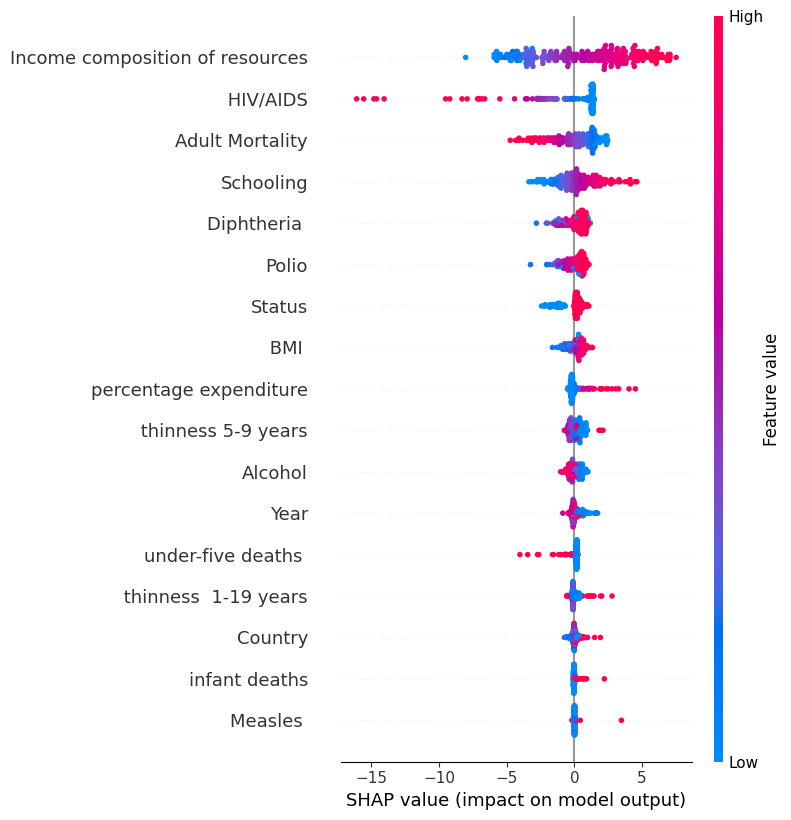

In [ ]:
shap.initjs()

feature_names = df.columns

shap.summary_plot(shap_values[0], all_test_data_inputs.numpy(), feature_names)

## Deep SHAP

In [ ]:
# torch.set_grad_enabled(True)
e = shap.DeepExplainer(model, all_train_data_inputs)

# Get the shap values from my test data (this explainer likes tensors)
shap_values_e = e.shap_values(all_test_data_inputs)

# Plots
#shap.force_plot(explainer.expected_value, shap_values, feature_names)
#shap.dependence_plot("b1_price_avg", shap_values, data, feature_names)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
len(shap_values_e)

257

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


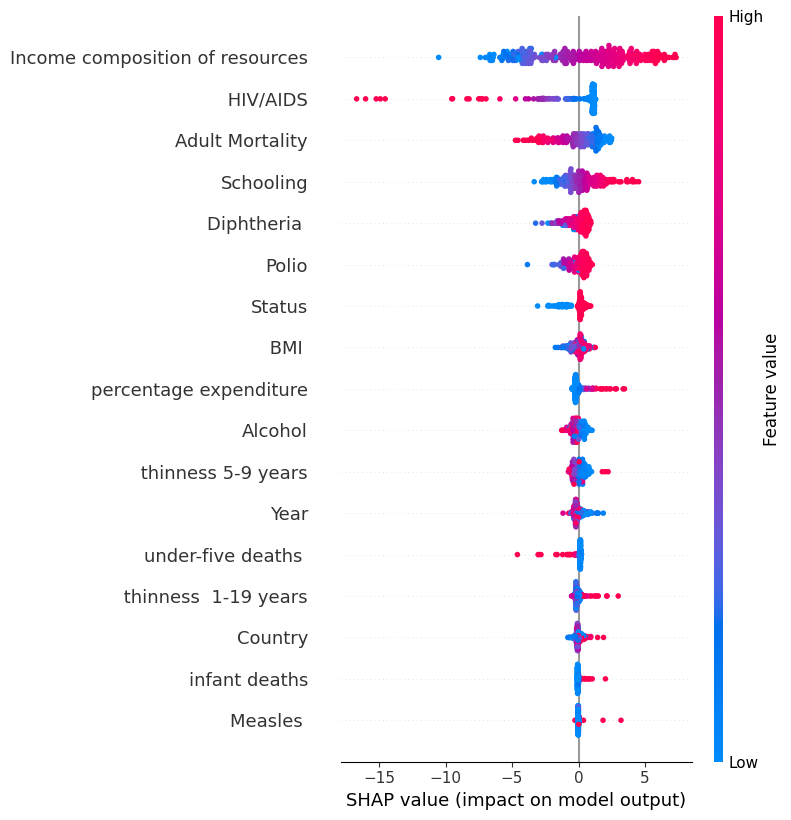

In [ ]:
shap.summary_plot(shap_values_e, all_test_data_inputs, feature_names)

## Final part

0.011765 is for algeria

0.017647 is for angola

`Algeria` is truly on the test:

In [ ]:
x_test.loc[(x_test['Country'] <= 0.0117666) & (x_test['Country'] >= 0.011764)] #Algeria

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
41,0.011765,0.4,1.0,0.18144,0.011111,0.019597,0.013873,0.004449,0.641261,0.0092,0.958333,0.958763,0.0,0.217391,0.207018,0.723629,0.594203


`Angola` is on the test dataframe too:

In [ ]:
x_test.loc[(x_test['Country'] <= 0.017648) & (x_test['Country'] >= 0.017646)].index #Angola

Int64Index([52], dtype='int64')

Finding location of `algeria` and `angola` on our test dataset:

In [ ]:
x_test.index.get_loc(41) #algeria

64

In [ ]:
x_test.index.get_loc(52) #angola

59

In [ ]:
all_test_data_inputs[64]

tensor([0.0118, 0.4000, 1.0000, 0.1814, 0.0111, 0.0196, 0.0139, 0.0044, 0.6413,
        0.0092, 0.9583, 0.9588, 0.0000, 0.2174, 0.2070, 0.7236, 0.5942])

In [ ]:
all_test_data_inputs[64].unsqueeze(0).size()

torch.Size([1, 17])

In [ ]:
# torch.set_grad_enabled(True)
e_algeria = shap.DeepExplainer(model, all_train_data_inputs)

# Get the shap values from my test data (this explainer likes tensors)
shap_values_e_algeria = e_algeria.shap_values(all_test_data_inputs[64].unsqueeze(0))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
shap_values_e_algeria

array([[ 2.24412709e-01, -2.12549508e-01,  1.05772108e-01,
         3.48810077e-01, -2.42482573e-02,  4.48327959e-01,
        -1.83479548e-01, -2.59103477e-02,  1.70578748e-01,
         5.86711913e-02,  3.66551250e-01,  4.46663022e-01,
         1.13513231e+00, -1.70698181e-01, -2.69997895e-01,
         6.09013975e-01,  7.69657927e-05]])

In [ ]:
e_algeria.expected_value

array([69.40189], dtype=float32)

In [ ]:
shap.initjs()
shap.force_plot(base_value=e_algeria.expected_value, shap_values=shap_values_e_algeria, features=feature_names)
# shap.plots.force(shap_values[0])

In [ ]:
# torch.set_grad_enabled(True)
e_angola = shap.DeepExplainer(model, all_train_data_inputs)

# Get the shap values from my test data (this explainer likes tensors)
shap_values_e_angola = e_angola.shap_values(all_test_data_inputs[59].unsqueeze(0))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
shap_values_e_angola

array([[-0.65694904, -0.50304705,  0.33421972, -3.17958951,  0.07863149,
        -0.88941956, -0.22550374, -0.00491009, -0.43773627, -0.35456535,
        -0.87848115, -0.97907567, -0.89749432, -0.07376704, -0.44783625,
        -3.66080141, -0.99945521]])

In [ ]:
e_angola.expected_value

array([69.40189], dtype=float32)

In [ ]:
shap.initjs()
shap.force_plot(base_value=e_angola.expected_value, shap_values=shap_values_e_angola, features=feature_names)
# shap.plots.force(shap_values[0])

# Question 4 - LIME

In this task, we aim to familiarize ourselves with the mechanism and functionality of LIME (Local Interpretable Model-agnostic Explanations). As its name suggests, LIME is a model-agnostic approach that treats the model as a black box, allowing it to be used for interpreting any machine learning model.

The core idea of LIME is to zoom into the local region around each individual prediction. This enables the generation of a valid explanation specific to that local area, without concern for the rest of the model. This approach provides reliable insights into why the model made a particular prediction. For further details, you can refer to the [original paper](https://arxiv.org/pdf/1602.04938.pdf?source=post_page---------------------------).

To complete this task, you are encouraged to use the [LIME library](https://lime-ml.readthedocs.io/en/latest/index.html) in Python. You may also choose to implement it manually if desired. Since this task involves working with images, you should use the library's `lime_image` module.

The model selected for this task is MobileNetV2. You can access and test this model to explore its functionality through [this link](https://michaelfeil.eu/web-tfjs/).

Steps to Complete this Task:

1. Retrieve the trained MobileNetV2 model in your chosen framework (e.g., [PyTorch](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) or [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2)).
Links to the respective frameworks can provide details for accessing the model.
The pre-trained model has been trained on the ImageNet dataset. You can find the list of classes in the ImageNet dataset through [this link](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt).

2. Choose a category from the ImageNet dataset.
Search the internet for images belonging to this category and select one image.
Test your model on this image and display the top 5 categories with the highest probabilities (i.e., similarities) from the model's output.

3. Once you confirm the model is functioning correctly, use the `lime` library for interpretation.
Define the relevant module from the library for working with images.

4. Use the `skimage` package to draw boundaries on the image based on the output from `lime_image`.

5. Overlay annotations for the pros and cons on the image, along with the identified boundaries.

6. Create a heatmap of the image showing the importance of different regions and their corresponding weights. This will allow you to see which areas of the image were most influential in the model’s decision-making process.

7. Perform the same steps for two other images. Try to include one image that contains objects from multiple categories (i.e., a multi-class image).

8. After completing the above steps, carefully analyze the results obtained for each image and for each stage.



For implementation of this part I used the help of:


1.   Original repository of LIME library: https://github.com/marcotcr/lime
2.   MobileNet V2 page of PyTorch Hub: https://pytorch.org/hub/pytorch_vision_mobilenet_v2/



Loading the pretrained model of MobileNet V2:

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
clear_output()

Testing the model on a random `axolotl`, `crate` and `sports car` image from the web:

In [ ]:
# Download an example image for each class from the web
url_axolotl, filename_axolotl = ("https://media.npr.org/assets/img/2021/09/14/axolotl_wide-72e2d02229ab32b28e454922ff48c841e69906a1-s1400-c100.jpg",
                 "axolotl.jpg")

url_crate, filename_crate = ("https://m.media-amazon.com/images/I/91xnGcjzDsL._AC_UF1000,1000_QL80_.jpg",
                 "crate.jpg")

url_sports_car, filename_sports_car = ("https://img.freepik.com/premium-photo/horses-pasture-near-expensive-mustang-car_713163-1690.jpg?w=2000",
                 "sports_car.jpg")

try:
    urllib.URLopener().retrieve(url_axolotl, filename_axolotl)
    urllib.URLopener().retrieve(url_crate, filename_crate)
    urllib.URLopener().retrieve(url_sports_car, filename_sports_car)
except:
    urllib.request.urlretrieve(url_axolotl, filename_axolotl)
    urllib.request.urlretrieve(url_crate, filename_crate)
    urllib.request.urlretrieve(url_sports_car, filename_sports_car)


Load our test images and see how they look:

In [ ]:
filenames = [filename_axolotl, filename_crate, filename_sports_car]

input_images = list()
for filename in filenames:
    input_images.append(Image.open(filename).convert('RGB'))


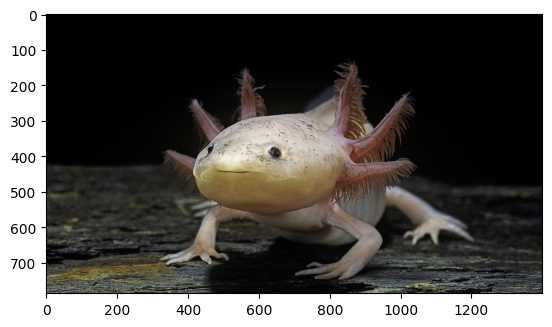

In [ ]:
# axolotl
plt.imshow(input_images[0])

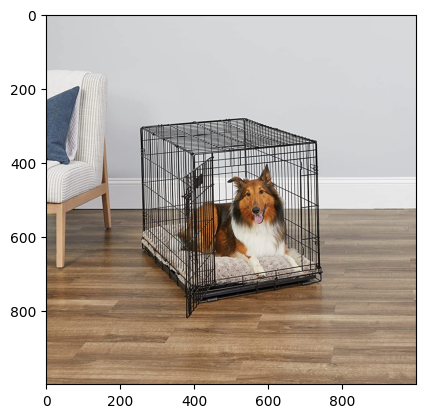

In [ ]:
# crate
plt.imshow(input_images[1])

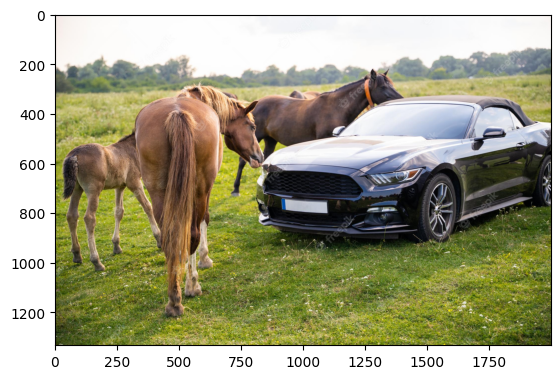

In [ ]:
# sports_car
plt.imshow(input_images[2])

*NOTE:* All pre-trained models expect input images normalized in the same way.

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensors = list()
for input_image in input_images:
    input_tensors.append(preprocess(input_image))

input_batch = torch.stack(input_tensors, dim=0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

model.eval()
with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(f'The output shape is {output.shape}')
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = F.softmax(output, dim=1)
print(f'The probabilities shape is {probabilities.shape}')

The output shape is torch.Size([3, 1000])
The probabilities shape is torch.Size([3, 1000])


In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
clear_output()

Down below you can see the results of the model on test images:

In [ ]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for j in range(len(filenames)):
    print(filenames[j])
    for i in range(top5_prob[j].size(0)):
        print(categories[top5_catid[j][i]], top5_prob[j][i].item())
    print()

axolotl.jpg
axolotl 0.9999990463256836
fiddler crab 2.4327985670424823e-07
puffer 2.3101929969016055e-07
loggerhead 6.761392512544262e-08
isopod 5.843322270493445e-08

crate.jpg
Shetland sheepdog 0.9066499471664429
collie 0.05859454348683357
papillon 0.007857265882194042
Pembroke 0.0046843127347528934
basset 0.0037432995159178972

sports_car.jpg
sorrel 0.8981277942657471
ox 0.036616694182157516
plow 0.02187727950513363
worm fence 0.013949239626526833
oxcart 0.012824221514165401



LIME produces array of images by perturbating the original image which we want an explanation for. So we need two steps:

1.   Original image as numpy array
2.   Classification function in order to classfiy perturbated images



For Pytroch we need to define two seperate transforms:

In [ ]:
transform_1 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224)
])

transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Here, we define our classification function:

In [ ]:
def clf(images):
    model.eval()
    input_batch = torch.stack(tuple(transform_2(i) for i in images))

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    model.eval()
    with torch.no_grad():
        output = model(input_batch)
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = F.softmax(output, dim=1)
    return probabilities.detach().cpu().numpy()

It's time for explain our prediction:

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanations = list()
for input_image in input_images:
    explanations.append(explainer.explain_instance(np.array(transform_1(input_image)),
                                            clf, # classification function
                                            top_labels=5,
                                            hide_color=0,
                                            num_samples=1000) # number of images that will be sent to classification function
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
temp1 = list()
mask1 = list()
temp2 = list()
mask2 = list()
img_boundry1 = list()
img_boundry2 = list()

for explanation in explanations:
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    temp1.append(temp)
    mask1.append(mask)

    img_boundry1.append(mark_boundaries(temp/255.0, mask))

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5 , hide_rest=False)
    temp2.append(temp)
    mask2.append(mask)

    img_boundry2.append(mark_boundaries(temp/255.0, mask))

Plot the explanations for each image:

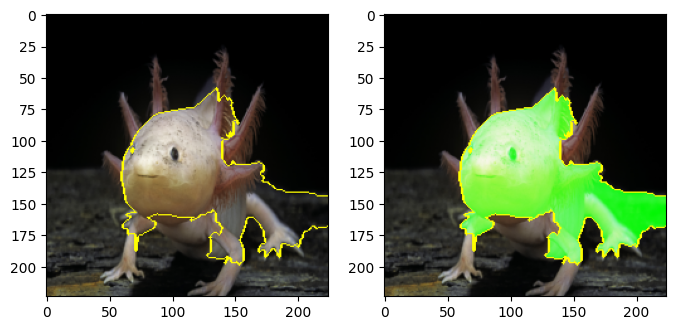

In [ ]:
# axolotl
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.imshow(img_boundry1[0])

plt.subplot(1, 2, 2)
plt.imshow(img_boundry2[0])

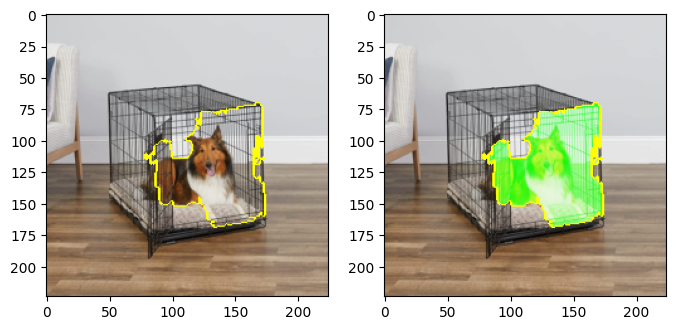

In [ ]:
# crate
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.imshow(img_boundry1[1])

plt.subplot(1, 2, 2)
plt.imshow(img_boundry2[1])

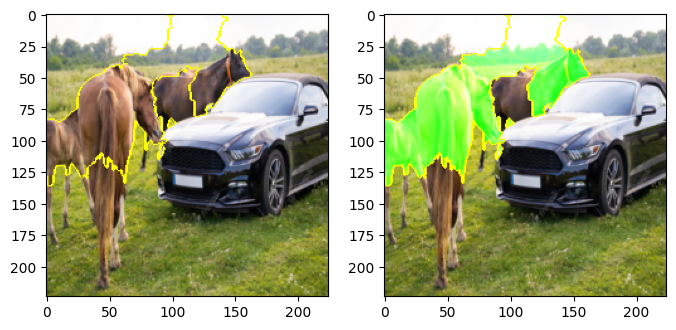

In [ ]:
# sports_car
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.imshow(img_boundry1[2])

plt.subplot(1, 2, 2)
plt.imshow(img_boundry2[2])

Let's show the heatmap:

In [ ]:
class_idx = list()
heatmap = list()
# Select the same class explained on the figures above.
for index, explanation in enumerate(explanations):
    class_idx.append(explanation.top_labels[0])
    # Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[class_idx[index]])
    heatmap.append(np.vectorize(dict_heatmap.get)(explanation.segments))

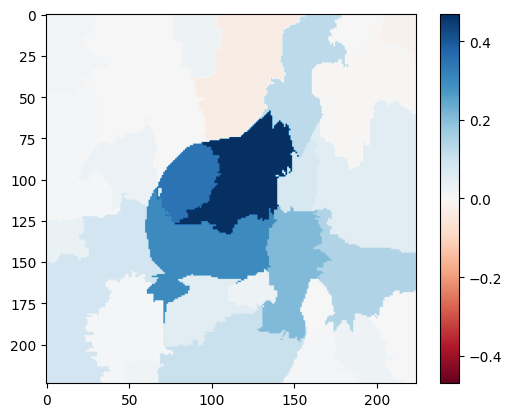

In [ ]:
# axolotl
plt.imshow(heatmap[0], cmap = 'RdBu', vmin  = -heatmap[0].max(), vmax = heatmap[0].max())
plt.colorbar()

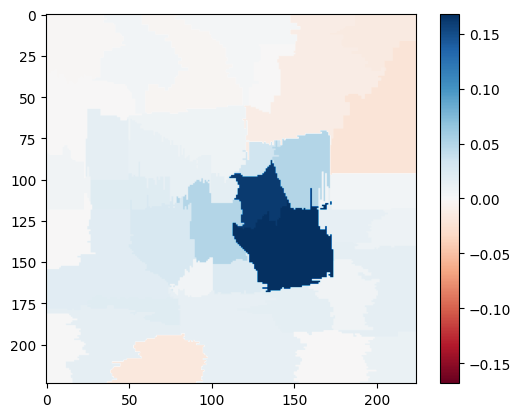

In [ ]:
# crate
plt.imshow(heatmap[1], cmap = 'RdBu', vmin  = -heatmap[1].max(), vmax = heatmap[1].max())
plt.colorbar()

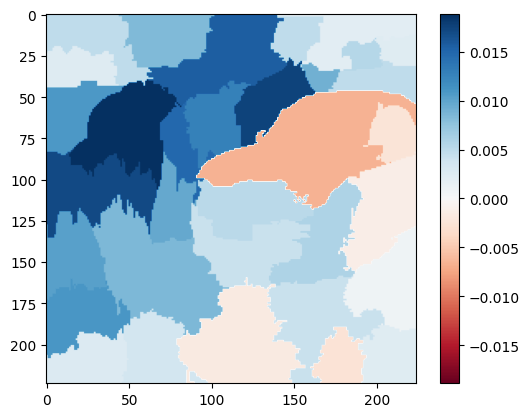

In [ ]:
# sports_car
plt.imshow(heatmap[2], cmap = 'RdBu', vmin  = -heatmap[2].max(), vmax = heatmap[2].max())
plt.colorbar()